In [1]:
%reload_ext autoreload
%autoreload 2

The following example was taken from Reddy (2005) "An introduction to non-linear finite element analysis" Section 9.4.5.

Here we present numerical results obtained for a cantilevered rectangular plate of length a = 10 in, height b = 1 in, and thickness h = 0:1 in, and subjected to uniformly distributed in-plane load ty = -q0, acting downward, along its length. The material of the plate has a modulus of elasticity E = 1.2E7 psi and Poisson's ratio of nu = 0.3.

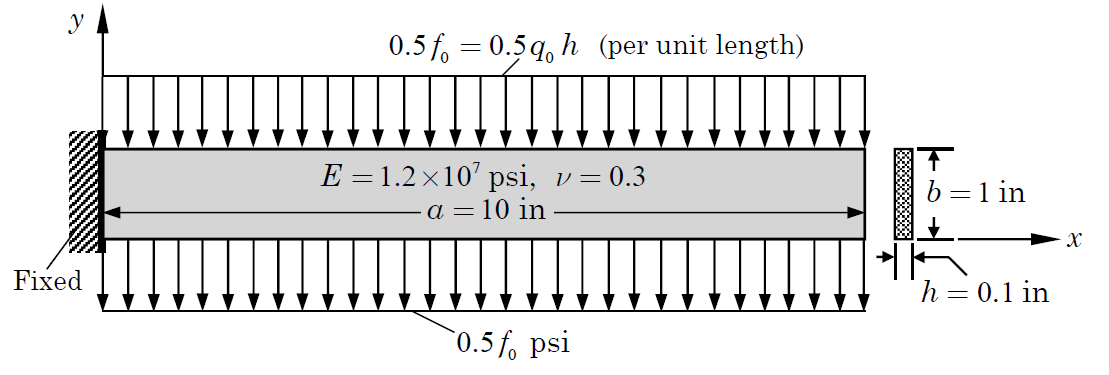

### General Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In [3]:
from mesh_utils import UniformQuadMesh2D

lx = 10                 # Dimension along x-coord
ly = 1                  # Dimension along y-coord
nx = 4                  # Number of elements along x-coord
ny = 1                  # Number of elements along y-coord
element_type = 'Q4'     # Type of elements

cantilever_mesh = UniformQuadMesh2D(lx, ly, nx, ny, elem_type=element_type)
cantilever_mesh.compute()

formulation = 'TLF'  # 'infinitesimal', 'TLF'

In [4]:
print(f'\nNodal coordinates:\n {cantilever_mesh.coordinates}')
print(f'\nElement connectivity:\n {cantilever_mesh.elements}')

print(f'\nNumber of nodes: {cantilever_mesh.nnod}')
print(f'Number of elements: {cantilever_mesh.nelem}')


Nodal coordinates:
 [[ 0.   0. ]
 [ 2.5  0. ]
 [ 5.   0. ]
 [ 7.5  0. ]
 [10.   0. ]
 [ 0.   1. ]
 [ 2.5  1. ]
 [ 5.   1. ]
 [ 7.5  1. ]
 [10.   1. ]]

Element connectivity:
 {'quad': [array([7, 6, 1, 2]), array([8, 7, 2, 3]), array([9, 8, 3, 4]), array([10,  9,  4,  5])]}

Number of nodes: 10
Number of elements: 4


In [5]:
cantilever_mesh.node_groups

{'all': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'bottom': [1, 2, 3, 4, 5],
 'top': [6, 7, 8, 9, 10],
 'left': [1, 6],
 'right': [5, 10]}

In [6]:
cantilever_mesh.element_groups

{'all': [1, 2, 3, 4],
 'bottom': [1, 2, 3, 4],
 'top': [1, 2, 3, 4],
 'left': [1],
 'right': [4]}

### Dirichlet boundary conditions

In [7]:
from feinn_solver import BoundaryCondition

cantilever_bc = {
                'left': [BoundaryCondition(dof=1, value=0.0),
                        BoundaryCondition(dof=2, value=0.0)]
                }

### Define material

In [8]:
from matmodels import LinearElasticPlaneStress

dummy_mat = LinearElasticPlaneStress(emod = 1.2*1e7, nu = 0.20)

cantilever_matfld = {'all': dummy_mat}

### von Neumman boundary conditions

In [9]:
from feinn_solver import EdgeLoad

cantilever_edge_loads = {
                        'top': EdgeLoad(side = 1, ftangential = 0.0, fnormal = -450, reference = "global"),
                        'bottom': EdgeLoad(side = 3, ftangential = 0.0, fnormal = -450, reference = "global"),
                        }


cantilever_edge_loads_2 = {
                        'top': EdgeLoad(side = 1, ftangential = 0.0, fnormal = -600, reference = "global"),
                        'bottom': EdgeLoad(side = 3, ftangential = 0.0, fnormal = -600, reference = "global"),
                        }

### Model

In [10]:
from feinn_solver import NFEA

cantilever_thickness = {
                        'all': 0.1
                        }

cantilever_fem = NFEA(mesh = cantilever_mesh, 
                      bcs = cantilever_bc, 
                      matfld = cantilever_matfld,
                      thickness = cantilever_thickness,
                      edge_loads = cantilever_edge_loads,
                      verbose = True
                      )

[matfld] Assigned: ['all']
[matfld] All 4 elements have assigned material
[thickness] Applied 1 thickness groups
[edge_load] Applied 2 edge load groups
[BC] Processed 2 Dirichlet condition(s) → 4 total constraint(s)
[BC] Applied Dirichlet BCs → 4 fixed DOFs


In [11]:
cantilever_fem.Fext_total

tensor([   0., -225.,    0., -450.,    0., -450.,    0., -450.,    0., -225.,
           0., -225.,    0., -450.,    0., -450.,    0., -450.,    0., -225.])

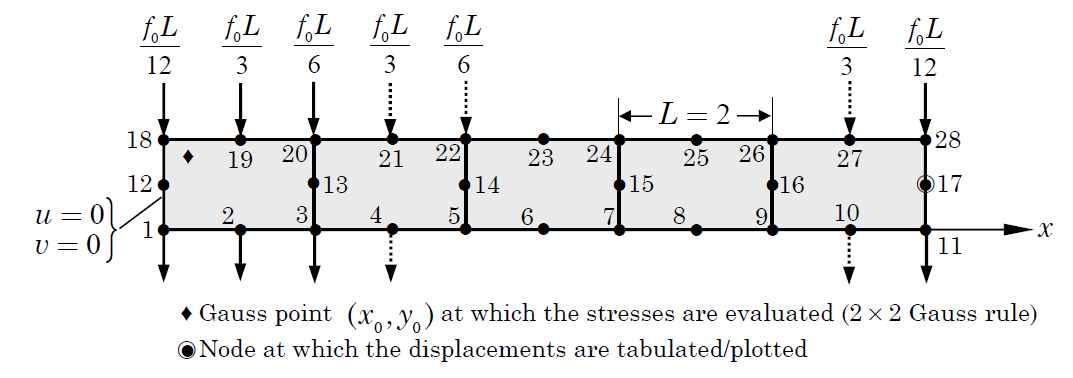

In [12]:
cantilever_fem.formulation = formulation
cantilever_fem.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 8.94e+01  Energetic error: -6.29e+03
Iter   2 | du error: 6.73e-02  Res error: 1.59e+00  Energetic error: 5.50e+01
Iter   3 | du error: 1.42e-03  Res error: 6.64e-04  Energetic error: 4.85e-04
Iter   4 | du error: 4.42e-05  Res error: 2.12e-07  Energetic error: 1.73e-10
Iter   5 | du error: 1.33e-09  Res error: 6.86e-13  Energetic error: -4.49e-20
Converged in 5 iterations


In [13]:
cantilever_fem.udisp

tensor([ 0.0000,  0.0000, -0.0521, -0.1332, -0.0959, -0.4415, -0.1359, -0.8321,
        -0.1724, -1.2475,  0.0000,  0.0000,  0.0435, -0.1374,  0.0488, -0.4521,
         0.0277, -0.8455, -0.0051, -1.2616])

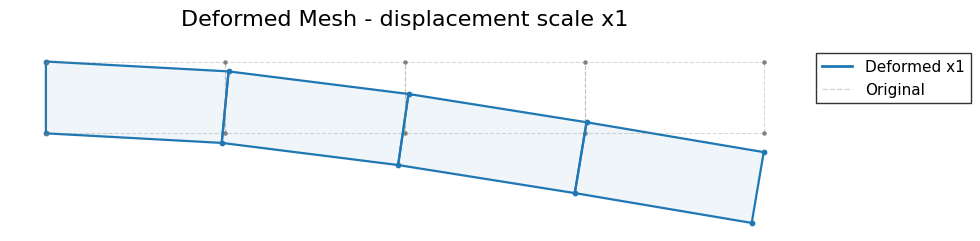

In [14]:
cantilever_fem.plot_deformed_mesh(scale=1)

In [15]:
Fint_fem = cantilever_fem._assemble_internal_forces(cantilever_fem.udisp)
Fint_fem

tensor([ 1.7886e+04,  1.6565e+03,  3.0923e-11, -4.5000e+02, -2.0009e-11,
        -4.5000e+02,  7.0486e-11, -4.5000e+02,  1.6527e-11, -2.2500e+02,
        -1.7886e+04,  1.4935e+03, -5.0932e-11, -4.5000e+02, -6.7303e-11,
        -4.5000e+02,  1.4779e-11, -4.5000e+02, -9.1319e-11, -2.2500e+02])

In [16]:
from feinn_solver import FEINN
from nn_models import mFCNet, FCResNet
import torch.nn as nn

feinn_solver = FEINN(
    mesh=cantilever_mesh,
    bcs=cantilever_bc,
    matfld=cantilever_matfld,
    thickness = cantilever_thickness,
    edge_loads=cantilever_edge_loads,
    verbose=False,
    nnet = mFCNet(),
    bc_weight=1e6,
    nnet_init = 'xavier',
    )

feinn_solver.formulation = formulation

In [17]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

cfg.epochs = 0
cfg.learning_rate = 1e-2
cfg.lr_min = 1e-5

In [18]:
import torch

optimizer = torch.optim.Adam(
    feinn_solver.nnet.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

# Entrenar
feinn_solver.train(epochs = cfg.epochs, 
                   optimizer = optimizer, 
                   scheduler = scheduler,
                   lbfgs_epochs = 100,
                   warmup = True, 
                   verbose = True)

[FEINN] Starting warmup for zero initial displacement
[FEINN] Warmup completado - salida inicial ≈ 0
[FEINN] Zero-output init: max |u| inicial = 8.71e-03

Epoch 1/100 (L-BFGS)
Total Loss: 1.598e+03
  Domain: 7.057e+01
  BC:     8.289e+01

Epoch 100/100 (L-BFGS)
Total Loss: 5.836e-10
  Domain: 3.453e-10
  BC:     2.383e-10


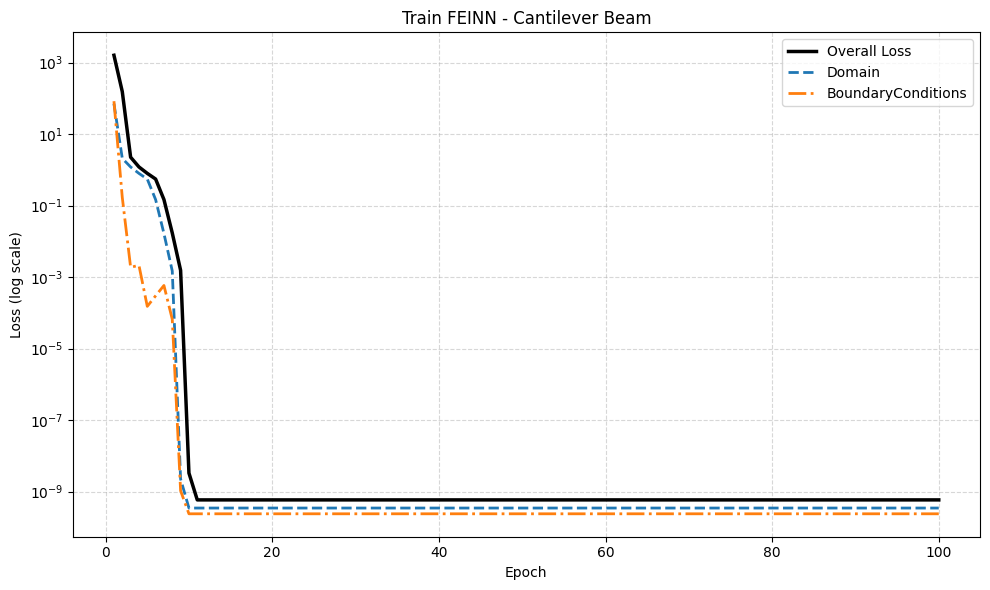

In [19]:
feinn_solver.plot_history(title="Train FEINN - Cantilever Beam")

In [20]:
cantilever_fem.udisp/feinn_solver.udisp

tensor([-0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0001, 1.0000])

In [21]:
feinn_solver.udisp

tensor([-9.7307e-09,  2.3584e-08, -5.2076e-02, -1.3320e-01, -9.5926e-02,
        -4.4150e-01, -1.3586e-01, -8.3207e-01, -1.7239e-01, -1.2475e+00,
         6.8722e-09,  1.5975e-08,  4.3474e-02, -1.3737e-01,  4.8809e-02,
        -4.5206e-01,  2.7682e-02, -8.4553e-01, -5.1032e-03, -1.2616e+00])

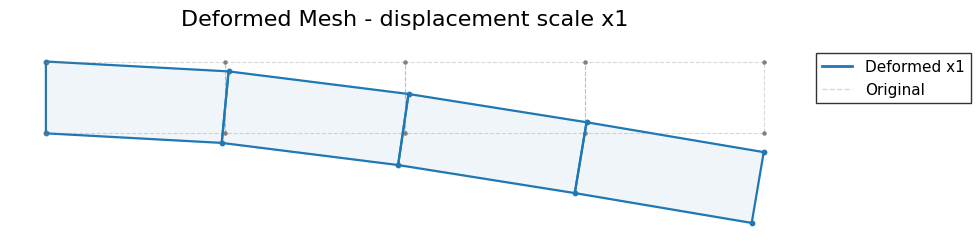

In [22]:
feinn_solver.plot_deformed_mesh(scale=1)

In [23]:
Fint_nn = feinn_solver._assemble_internal_forces(feinn_solver.udisp)
Fint_nn

tensor([ 1.7886e+04,  1.6565e+03,  7.2604e-03, -4.5000e+02,  8.9588e-04,
        -4.5000e+02,  2.0550e-03, -4.5000e+02,  8.6471e-03, -2.2500e+02,
        -1.7886e+04,  1.4935e+03,  6.6444e-03, -4.5001e+02, -3.4588e-04,
        -4.5000e+02,  1.0531e-02, -4.5000e+02, -7.4637e-04, -2.2500e+02])

In [24]:
Fint_fem

tensor([ 1.7886e+04,  1.6565e+03,  3.0923e-11, -4.5000e+02, -2.0009e-11,
        -4.5000e+02,  7.0486e-11, -4.5000e+02,  1.6527e-11, -2.2500e+02,
        -1.7886e+04,  1.4935e+03, -5.0932e-11, -4.5000e+02, -6.7303e-11,
        -4.5000e+02,  1.4779e-11, -4.5000e+02, -9.1319e-11, -2.2500e+02])

In [25]:
cantilever_fem.Fext_total

tensor([   0., -225.,    0., -450.,    0., -450.,    0., -450.,    0., -225.,
           0., -225.,    0., -450.,    0., -450.,    0., -450.,    0., -225.])

In [26]:
Fint_fem / Fint_nn

tensor([ 1.0000e+00,  1.0000e+00,  4.2591e-09,  1.0000e+00, -2.2334e-08,
         1.0000e+00,  3.4300e-08,  1.0000e+00,  1.9113e-09,  1.0000e+00,
         1.0000e+00,  1.0000e+00, -7.6653e-09,  9.9999e-01,  1.9458e-07,
         1.0000e+00,  1.4034e-09,  9.9999e-01,  1.2235e-07,  9.9998e-01])

In [27]:
Fint_nn[::2].sum()

tensor(-5.9117e-12)

In [28]:
Fint_fem[::2].sum()

tensor(1.3642e-12)

In [29]:
Fint_nn[1::2].sum()

tensor(-1.2506e-12)

In [30]:
Fint_fem[1::2].sum()

tensor(3.4106e-13)

In [31]:
with torch.no_grad():
    feinn_solver.udisp     = feinn_solver.nnet(feinn_solver.coords_tensor).reshape(-1).detach()

In [32]:
feinn_solver.udisp

tensor([-9.7307e-09,  2.3584e-08, -5.2076e-02, -1.3320e-01, -9.5926e-02,
        -4.4150e-01, -1.3586e-01, -8.3207e-01, -1.7239e-01, -1.2475e+00,
         6.8722e-09,  1.5975e-08,  4.3474e-02, -1.3737e-01,  4.8809e-02,
        -4.5206e-01,  2.7682e-02, -8.4553e-01, -5.1032e-03, -1.2616e+00])

In [33]:
cantilever_fem.udisp/feinn_solver.udisp

tensor([-0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0001, 1.0000])